# BLOSUM Comparison
Compare the Bacillus carbohydrate metabolism Protvec model with the BLOSUM62 matrix

In [1]:
#imports
import pickle
import numpy as np
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.spatial import distance
import seaborn as sns

In [3]:
#read in the bacillus Protvec model 
bacil_vec_df = pickle.load(open('../protvec_models/bacillus_3mervectors.pkl', 'rb'))
bacil_kmers = list(list(bacil_vec_df.keys()))
bacil_vec = np.stack([bacil_vec_df.get(kmer) for kmer in bacil_kmers], axis = 0)

## PCA of the 3-mer vectors

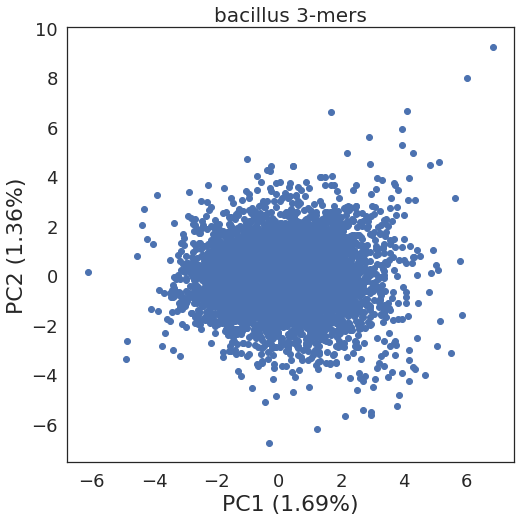

In [117]:
## do PCA on the Bacillus Protvec model
bacil_scaled = StandardScaler().fit_transform(bacil_vec) 
bacil_scaled = pd.DataFrame(bacil_scaled, columns = [i for i in range(100)])
bacil_scaled.index = bacil_kmers

pca_s = PCA(n_components = 2)
bacil_pca = pca_s.fit_transform(bacil_scaled)

bacil_pcaDf = pd.DataFrame(data = bacil_pca, columns = ['PC1', 'PC2'])
bacil_pcaDf = pd.concat([bacil_pcaDf, pd.DataFrame(bacil_kmers, columns = ['3-mers'])], axis = 1)

#get the expalined variance for the PCA 
bacil_var = pca_s.explained_variance_ratio_
x_label = 'PC1 ('+str(np.round(bacil_var[0]*100,2))+"%)"
y_label = 'PC2 ('+str(np.round(bacil_var[1]*100,2))+"%)"

#visualsise the bacil PCA  
fig3 = plt.figure(figsize = (8,8))
ax3 = fig3.add_subplot(1,1,1)
ax3.set_xlabel(x_label, fontsize = 22)
ax3.set_ylabel(y_label, fontsize = 22)
ax3.tick_params(axis='both', which='major', labelsize=18)
ax3.set_title('bacillus 3-mers', fontsize = 20) 
ax3.scatter(bacil_pcaDf['PC1'], bacil_pcaDf['PC2'])

## Investigate the length of 3-mer vectors 
Are there 3-mer vectors which have a greater affect on the embedding than others

/home/grig0076/.local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='dist', ylabel='Density'>

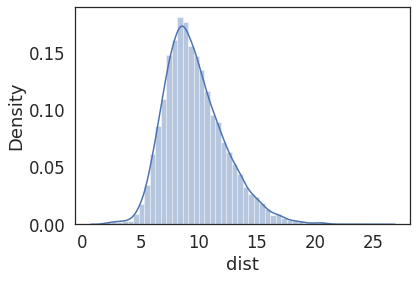

In [99]:
def dict_kmers(alphabet, kmers): 
    """Make a dictionary of the amino acids and which kmers they occur in"""
    
    #make a list of the amino acid occurances 
    alpha_occurances = []

    #iterate through the amino acids 
    for a in alphabet: 
    
        alpha_list = []
    
        for kmer in kmers: 
            if a in kmer: 
                alpha_list.append(kmer)
                
        alpha_occurances.append(alpha_list)
        
    #make into a dictionary 
    kmer_aa_dict = dict(zip(alphabet, alpha_occurances))
    
    return kmer_aa_dict

#see which kmers are furthest from the origin 
bacil_pcaDf_coord = bacil_pcaDf[['PC1', 'PC2']].values

origin = np.zeros(100)
bacil_dist = [distance.euclidean(origin, vec) for vec in bacil_scaled.values]

bacil_distDf = pd.DataFrame({'md5': bacil_kmers, 'dist': bacil_dist}).sort_values('dist', ascending = False)

#plot the distribution of the distances from the origin
sns.set(font_scale = 1.5, style = 'white')
sns.distplot(bacil_distDf['dist'])

Distribution is heavily tailed - which amino acids are associated with this tail? 

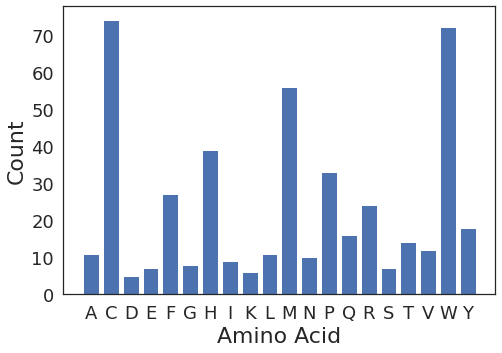

In [133]:
#get the occurances of each amino acid in the cluster furthest from the centre 
alphabet = [a for a in list(set(list(''.join(bacil_kmers)))) if a.isupper()]
#drop the letters which do not occur in the data 
alphabet = sorted(alphabet)

#get the 100 3-mer vectors with the greatest Euclidean distance from the origin 
bacil_1dist_aa = dict_kmers(alphabet,bacil_distDf[bacil_distDf['dist'] > 16]['md5'])
bacil_1dist_occurances = [len(bacil_1dist_aa.get(aa)) for aa in alphabet]

#plot the ocurance of each amino acid in the top 100 3-mers 
ymax = 159
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(alphabet,bacil_1dist_occurances)
ax.set_xlabel('Amino Acid', fontsize = 22)
ax.set_ylabel('Count', fontsize = 22)
ax.tick_params(axis='both', which='major', labelsize=18)
plt.show()

## Compare this amino acid distribution in the tail with the BLOSUM62 matrix

In [93]:
#read in blosum matrix .csv file 
BLOSUM = pd.read_csv('/home/grig0076/Protvec/AMSI_Ontology/notebooks/kmer_distribution/BLOSUM_62.csv')

#get the BLOSUM entries on the diagonal 
BLOSUM_diag = pd.DataFrame(np.diag(BLOSUM.values))
BLOSUM_diag.index = BLOSUM.columns
BLOSUM_diag.column = 'diagonal'

#Compare with counts 
protvec_counts = pd.DataFrame(bacil_1dist_occurances)
protvec_counts.index = alphabet
protvec_counts.column = 'counts'

blosum_df = pd.concat([BLOSUM_diag, protvec_counts], axis = 1)
blosum_df.columns = ['BLOSUM', 'Counts']

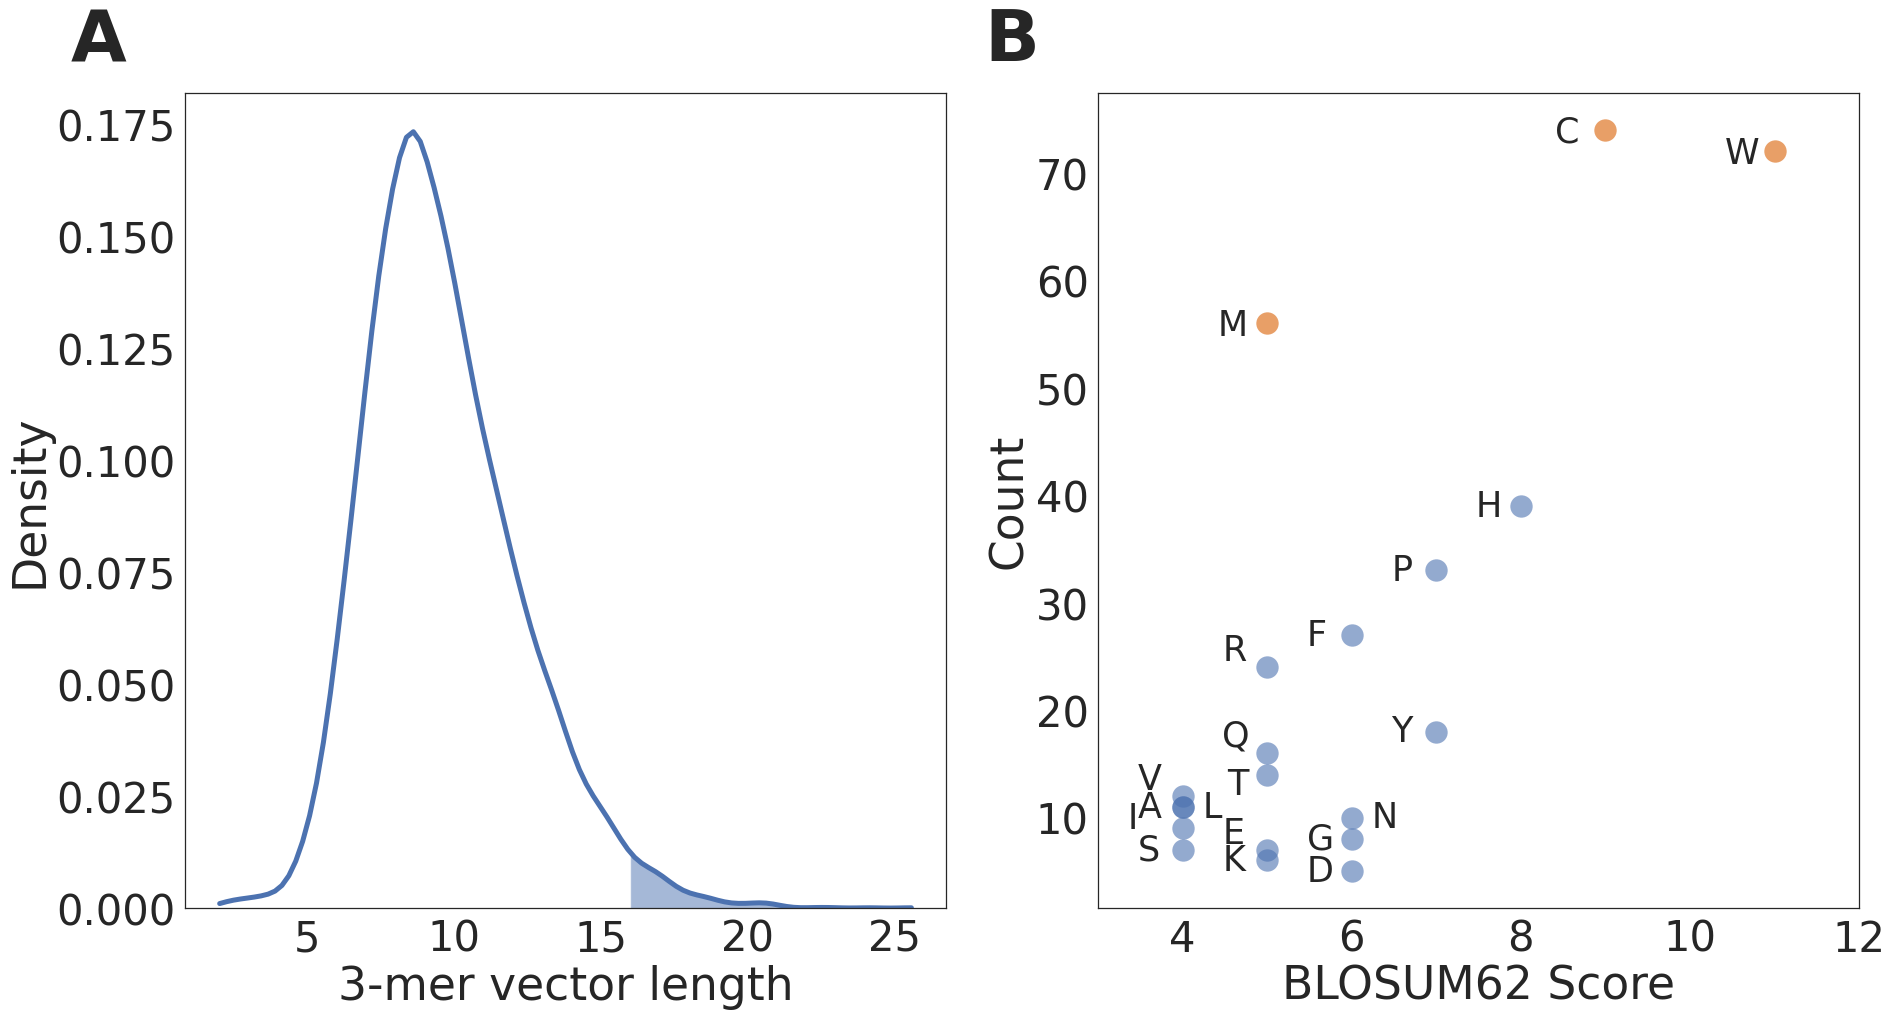

In [132]:
#create figure for manuscript 
sns.set(font_scale = 3.8, style = 'white')
fig, axes = plt.subplots(1, 2, sharex=False, figsize=(30,15))


dist = bacil_distDf['dist']
kde = stats.gaussian_kde(dist)
pos = np.linspace(dist.min(), dist.max(), 101)
axes[0].plot(pos, kde(pos), linewidth=5)
# plot shaded kde only right of x=0.5
shade = np.linspace(16,dist.max(), 101)
axes[0].fill_between(shade,kde(shade), alpha=0.5)


axes[1].set(xlim = (3,12), ylabel = 'Count', xlabel ='BLOSUM62 Score' )
axes[0].set(xlabel='3-mer vector length', ylabel= 'Density', ylim = (0,None))

ax1 = sns.scatterplot(ax=axes[1], x = blosum_df.drop(['W', 'C', 'M'])['BLOSUM'], y = blosum_df.drop(['W', 'C', 'M'])['Counts'],  alpha = 0.6, linewidth=0, s = 500)
for i, txt in enumerate(blosum_df.drop(['W', 'C', 'M']).index):
    if txt =='N' or txt == 'L': 
        ax1.annotate(txt, (blosum_df.drop(['W', 'C', 'M'])['BLOSUM'][i], blosum_df.drop(['W', 'C','M'])['Counts'][i]), xytext=(20, -10), textcoords='offset points',fontsize =35)
    elif txt =='I': 
        ax1.annotate(txt, (blosum_df.drop(['W', 'C', 'M'])['BLOSUM'][i], blosum_df.drop(['W', 'C', 'M'])['Counts'][i]), xytext=(-55, 0), textcoords='offset points',fontsize = 35)
    elif txt == 'R' or txt == 'Q' or txt == 'E'or txt == 'V': 
        ax1.annotate(txt, (blosum_df.drop(['W', 'C', 'M'])['BLOSUM'][i], blosum_df.drop(['W', 'C', 'M'])['Counts'][i]), xytext=(-45, 7), textcoords='offset points',fontsize = 35)
    elif txt == 'T': 
        ax1.annotate(txt, (blosum_df.drop(['W', 'C', 'M'])['BLOSUM'][i], blosum_df.drop(['W', 'C', 'M'])['Counts'][i]), xytext=(-40, -20), textcoords='offset points',fontsize = 35)
    else: 
        ax1.annotate(txt, (blosum_df.drop(['W', 'C', 'M'])['BLOSUM'][i], blosum_df.drop(['W', 'C', 'M'])['Counts'][i]), xytext=(-45, -10), textcoords='offset points',fontsize = 35)

ax2 = sns.scatterplot(ax=axes[1], x = blosum_df.loc[['W', 'C', 'M']]['BLOSUM'], y = blosum_df.loc[['W', 'C', 'M']]['Counts'], color = '#d95f02',  alpha = 0.6, linewidth=0, s = 500, )
for i, txt in enumerate(blosum_df.loc[['W', 'C', 'M']].index):
    ax2.annotate(txt, (blosum_df.loc[['W', 'C','M']]['BLOSUM'][i], blosum_df.loc[['W', 'C', 'M']]['Counts'][i]), fontsize = 35, xytext=(-50, -12), textcoords='offset points')

axes[0].annotate("A", xy=(-0.15, 1.04), xycoords="axes fraction", weight='bold', fontsize = 72)
axes[1].annotate("B", xy=(-0.15, 1.04), xycoords="axes fraction", weight='bold', fontsize = 72)

plt.savefig('Figure1.tiff', format='tiff')